###Dynamics: 
$$   \boldsymbol {\dot x} =f(\boldsymbol{x},\boldsymbol{u}) = f(\boldsymbol x)+g(\boldsymbol x)\boldsymbol u= \begin{bmatrix} 0 &0 &0 \\0&0 &0\\0&0 &0 \end{bmatrix}\begin{bmatrix} x\\y\ \\ \theta \end{bmatrix} + \begin{bmatrix} \cos \theta & 0\\ \sin θ & 0\\0 & 1\end{bmatrix}\begin{bmatrix} v\\ \dot \theta\end{bmatrix} \quad :\boldsymbol x \in \mathbb{R}^3, \boldsymbol u \in \mathbb{R}^2$$

###Optimal Control problem (finite horizon with terminal cost): 
$$\min_{u} \mathcal{L} = \boldsymbol x(t_f)^T \boldsymbol M \boldsymbol x(t_f) + \int_{0}^{t_f}(\boldsymbol x^T\boldsymbol Q \boldsymbol x+\boldsymbol u^T\boldsymbol R \boldsymbol u )dt \quad\text{   where  } \quad t_f=1, \boldsymbol Q =\boldsymbol I_{3 \times 3}, \boldsymbol R= \boldsymbol I_{2 \times 2}, \boldsymbol M= \boldsymbol I_{3 \times 3}$$

In [ ]:
!pip install casadi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.2 MB 1.8 MB/s 


In [1]:

"""
Created on Thu Oct 19 12:11:47 2022

@author: shubham
"""
from casadi import *
import numpy as np
import random
import matplotlib.pyplot as plt


In [20]:
T = 1# ##Time horizon
N = 20 ## Iterations
M = 4 ## RK4 steps per interval
int_state = [1.0,0, 3.141] #0,1,-pi/2,0,0 ##initial states
m = 3  ## terminal penalty multiplier
q = 6
r = 0.5

In [21]:
   
x = MX.sym('x',3)
u= MX.sym('u',2)

xdot = vertcat(u[0]*cos(x[2]), u[0]*sin(x[2]), u[1])
L = q*dot(x,x) + r*dot(u,u)
DT = T/N/M
f = Function('f', [x, u], [xdot, L])
X0 = MX.sym('X0', 3)
U = MX.sym('U',2)
X = X0
Q = 0
for j in range(M):
    k1, k1_q = f(X, U)
    k2, k2_q = f(X + DT/2 * k1, U)
    k3, k3_q = f(X + DT/2 * k2, U)
    k4, k4_q = f(X + DT * k3, U)
    X=X+DT/6*(k1 +2*k2 +2*k3 +k4)
    Q = Q + DT/6*(k1_q + 2*k2_q + 2*k3_q + k4_q)
F = Function('F', [X0, U], [X, Q],['x0','p'],['xf','qf'])

w=[]
w0 = []
lbw = []
ubw = []
J = 0
g=[]
lbg = []
ubg = []

Xk = MX(int_state) 
Uk = MX.sym('U', 2*N)
for k in range(N):
   
    lbw += [-inf,-inf]
    ubw += [inf,inf]
    
    u_rand= random.uniform(-10,10)
    psi_rand=random.uniform(-3,3)
    
    #a_rand=0 ; psi_rand=0 ################################################################### zero controls or no random controls
    
    #w0 += [a_rand,psi_rand] ################################################################initial controls

    # Integrate till the end of the interval
    Fk = F(x0=Xk, p=vertcat(Uk[2*k],Uk[2*k+1]))
    Xk = Fk['xf']
    Qk = Fk['qf']

    J=J+ Qk
    
    # # Add inequality constraint
    # g += [Xk[3],Xk[4]]                                     #[[Xk[3],Xk[4]]]
          
    # lbg += [-5,-pi/3]
    # ubg += [5,pi/3]

J=J+m*dot(Xk,Xk)



In [22]:
#x_temp=vcat(w)
#g_temp=vcat(g)
import time
start = time.time()

prob = {'f': J, 'x': Uk}
solver = nlpsol('solver', 'ipopt', prob)

sol = solver(x0=w0, lbx=lbw, ubx=ubw)


w_opt = sol['x']

# Plot the solution
u_opt = w_opt
x_opt = [int_state] 
for k in range(N):
    Fk = F(x0=x_opt[-1], p=vertcat(u_opt[2*k],u_opt[2*k+1]))
    x_opt += [Fk['xf'].full()]

x1_opt = [r[0] for r in x_opt]
x2_opt = [r[1] for r in x_opt]
x3_opt = [r[2] for r in x_opt]

u_dense = u_opt.full()
u1_opt=[]
u2_opt=[]
i=0
for r in u_dense:
    if i%2==0:
        u1_opt+=[r]
    else:
        u2_opt+=[r]
    i=i+1
    
end = time.time()


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      820

Total number of variables............................:       40
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/shubham/anaconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


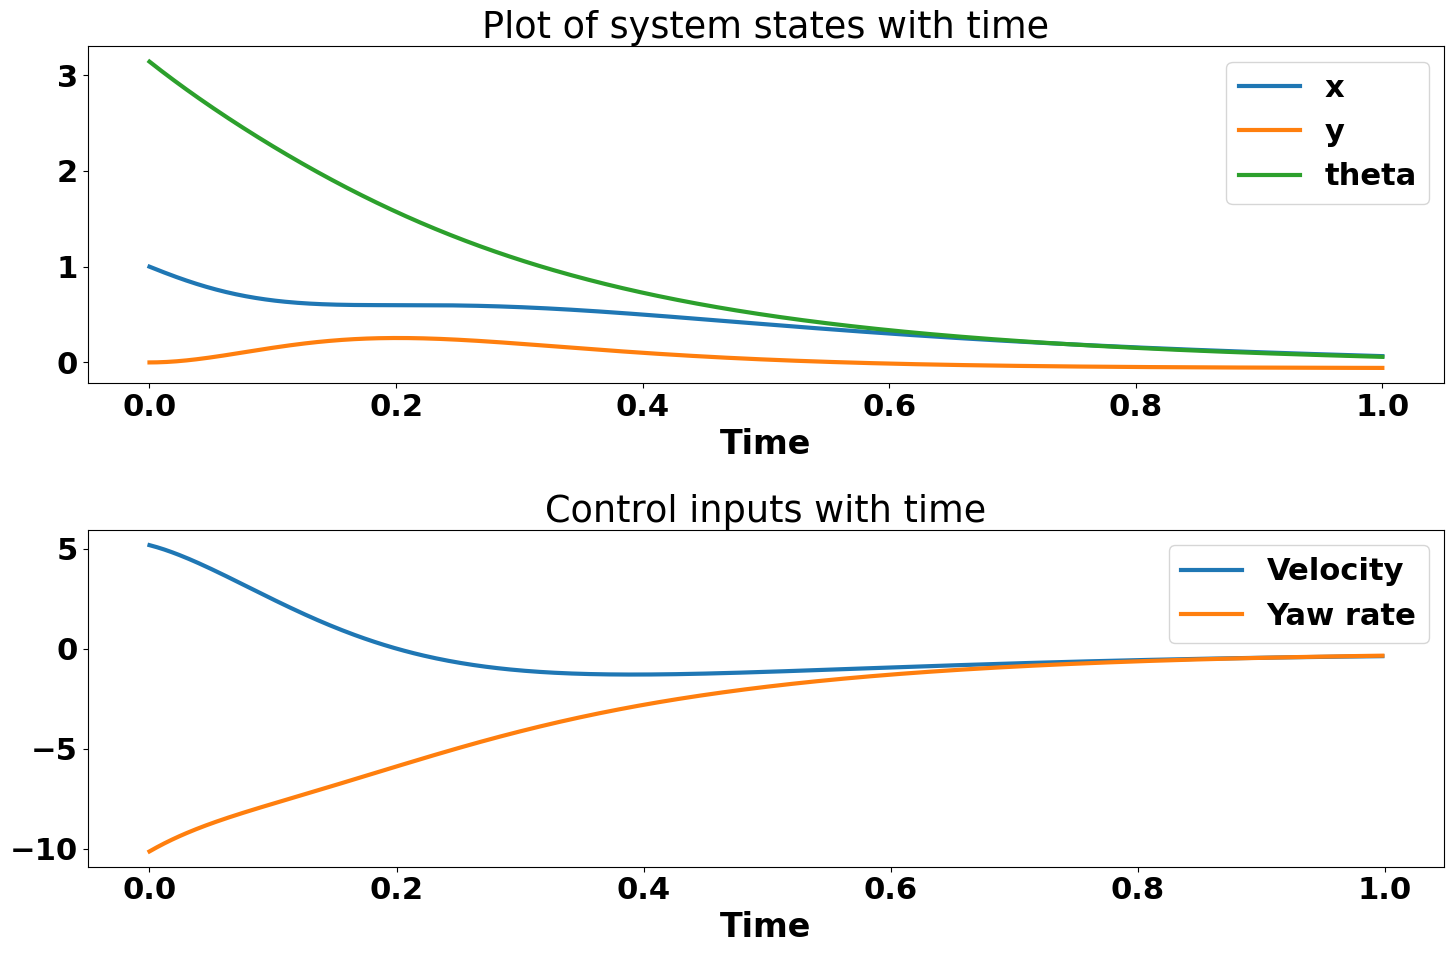

In [6]:
tgrid = [T/N*k for k in range(N+1)]

import matplotlib 
font = { 'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
#plt.clf()
plt.plot(tgrid, x1_opt,  linewidth=3)
plt.plot(tgrid, x2_opt,  linewidth=3)
plt.plot(tgrid, x3_opt,  linewidth=3)

plt.title('Plot of system states with time')
plt.xlabel('Time', fontsize=24, fontweight = 'bold')
plt.legend(['x','y','theta'])
#plt.savefig("Canvas12.png",dpi=500)

plt.subplot(2, 1, 2)
#plt.clf()
plt.plot(tgrid[:-1], u1_opt ,linewidth=3)
plt.plot(tgrid[:-1], u2_opt, linewidth=3)

plt.xlabel('Time' , fontsize=24, fontweight = 'bold')
plt.title('Control inputs with time')
plt.legend(['Velocity','Yaw rate'])
#plt.savefig("Canvas13.png",dpi=500)
plt.tight_layout()
plt.savefig("traj_2_shooting.png", dpi = 200)
plt.show()


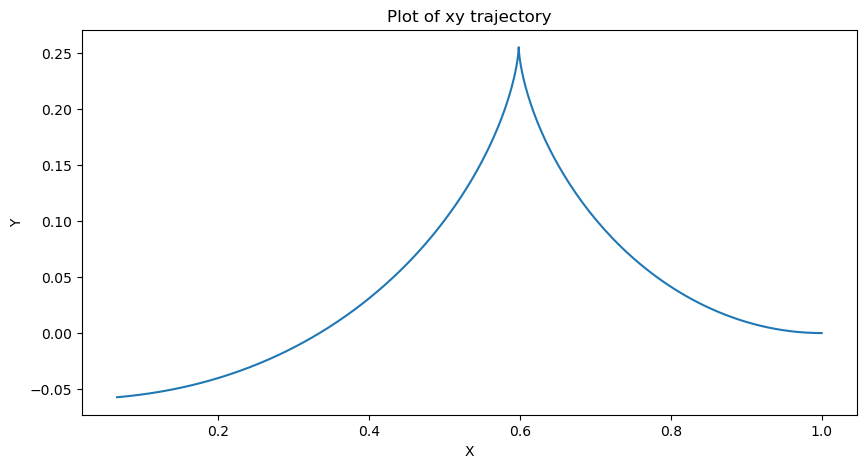

In [12]:
plt.figure(figsize=(10,5))
plt.plot(x1_opt,x2_opt )
plt.title('Plot of xy trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [23]:
tot_time = end - start
print(tot_time)

0.1737983226776123


In [37]:
x1 = numpy.hstack(x1_opt)
x2 = numpy.hstack(x2_opt)
x3 = numpy.hstack(x3_opt)
states = np.vstack((x1,x2,x3)).T


array([1.   , 0.   , 3.141])

In [38]:
import os

path = os.getcwd()
parent = os.path.dirname(path)
filename = parent+ '/sample_state_trajectories' +'/trajec_3_round_at_x_1_shoot.npy'
np.save(filename, states)